Generando datos simulados...
Datos creados: 300 clientes en 5 canales
------------------------------------------------------------

[VERIFICACIÓN DE ASUNCIONES]

Normalidad (Shapiro-Wilk):
Redes Sociales       p = 0.5272
Búsqueda Orgánica    p = 0.2573
Email Marketing      p = 0.1713
Publicidad Paga      p = 0.5129
Referidos            p = 0.5980

Homocedasticidad (Levene): p = 0.0001
Conclusión: Varianzas DESIGUALES → usar Welch ANOVA

[RESULTADOS ANOVA]
Método utilizado: Welch ANOVA
Estadístico F: 30.451
Valor p: 5.8014e-17
Conclusión: SE RECHAZA H0 (existen diferencias entre canales)

[PRUEBAS POST-HOC]
Canal A              | Canal B              | Diff       | p-aj    
----------------------------------------------------------------------
Redes Sociales       | Búsqueda Orgánica    | -83.38     | 0.0025
Redes Sociales       | Email Marketing      | -261.52    | 0.0000
Redes Sociales       | Publicidad Paga      | -116.11    | 0.0009
Redes Sociales       | Referidos            | -37

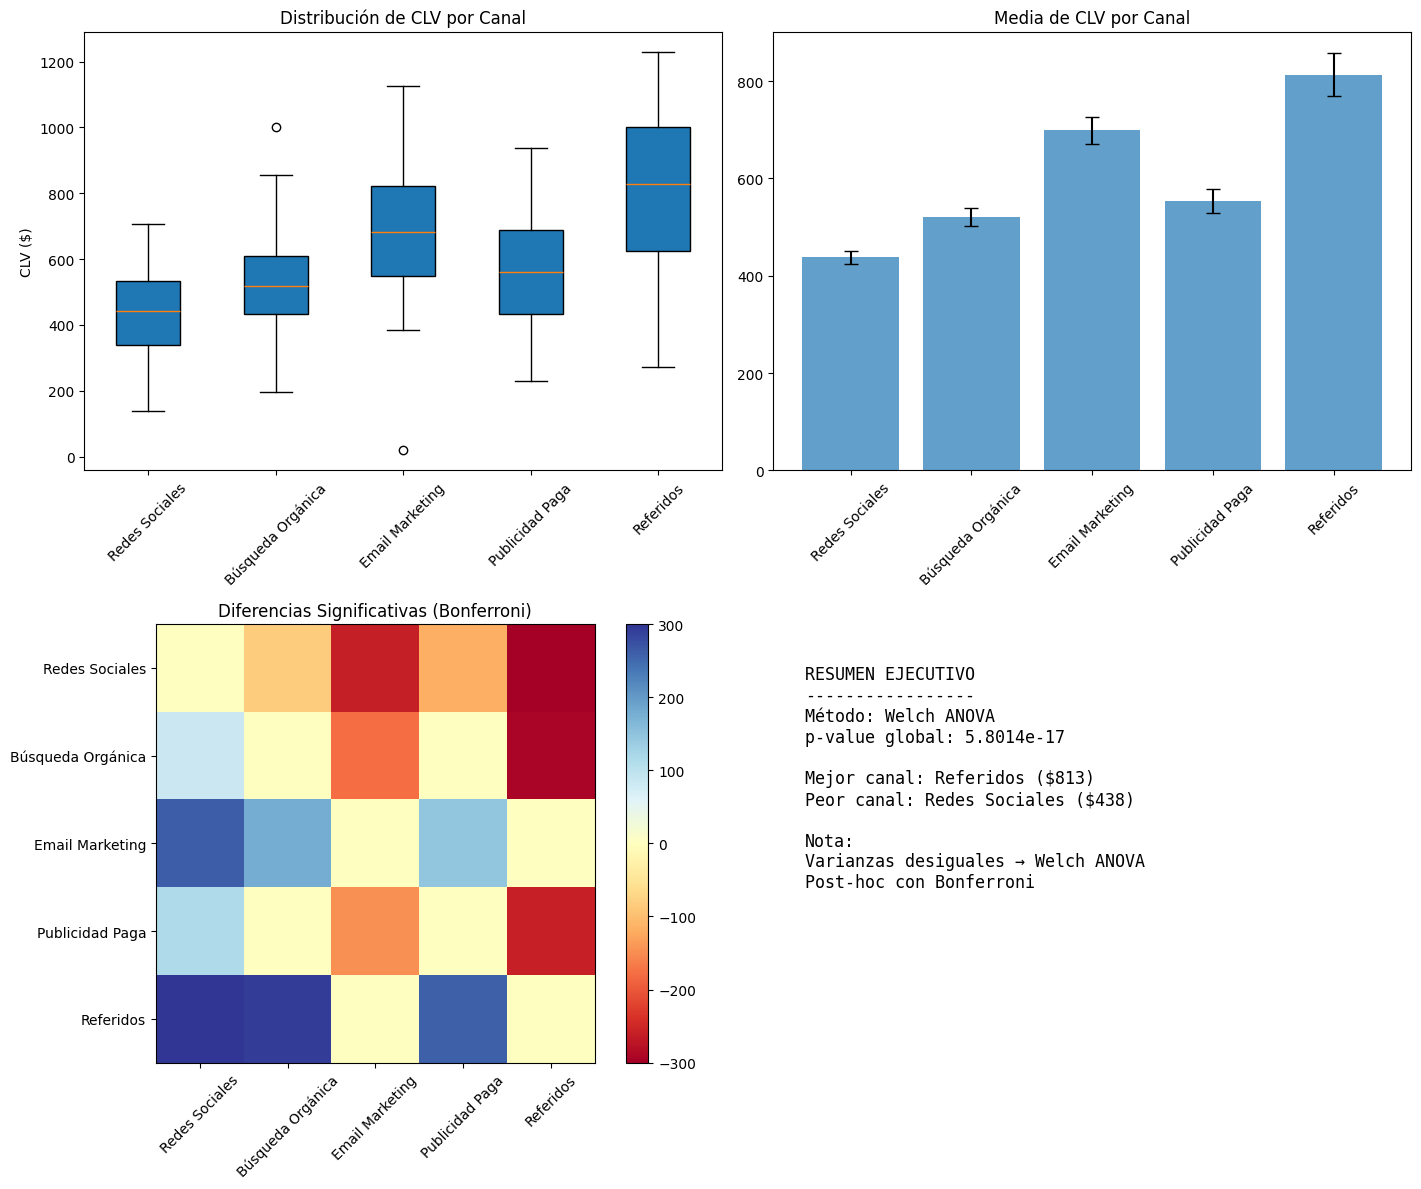

In [4]:
# ============================================================
# ANOVA – Segmentación de Clientes por Canal de Adquisición
# Día 3 | Estadística para Análisis de Datos
# ============================================================

import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.multitest import multipletests
from itertools import combinations
import matplotlib.pyplot as plt

# ============================================================
# 1. PREPARACIÓN DE DATOS
# ============================================================

print("Generando datos simulados...")
np.random.seed(42)
n_clientes = 300

canales = [
    'Redes Sociales',
    'Búsqueda Orgánica',
    'Email Marketing',
    'Publicidad Paga',
    'Referidos'
]

pesos_canales = [0.3, 0.25, 0.2, 0.15, 0.1]

canal_asignado = np.random.choice(
    canales,
    size=n_clientes,
    p=pesos_canales
)

clv_por_canal = {
    'Redes Sociales': 450,
    'Búsqueda Orgánica': 520,
    'Email Marketing': 680,
    'Publicidad Paga': 590,
    'Referidos': 750
}

clv_data = []
for canal in canal_asignado:
    media = clv_por_canal[canal]
    valor = np.random.normal(media, media * 0.30)
    clv_data.append(max(0, valor))

df = pd.DataFrame({
    'cliente_id': range(1, n_clientes + 1),
    'canal_adquisicion': canal_asignado,
    'clv': clv_data
})

print(f"Datos creados: {len(df)} clientes en {len(canales)} canales")
print("-" * 60)

# ============================================================
# 2. VERIFICACIÓN DE ASUNCIONES
# ============================================================

print("\n[VERIFICACIÓN DE ASUNCIONES]")

grupos_clv = {
    canal: df[df['canal_adquisicion'] == canal]['clv'].values
    for canal in canales
}

print("\nNormalidad (Shapiro-Wilk):")
for canal, datos in grupos_clv.items():
    stat, p = stats.shapiro(datos)
    print(f"{canal:<20} p = {p:.4f}")

stat_lev, p_lev = stats.levene(*grupos_clv.values())
print(f"\nHomocedasticidad (Levene): p = {p_lev:.4f}")

homocedasticidad = p_lev > 0.05

if homocedasticidad:
    print("Conclusión: Varianzas iguales")
else:
    print("Conclusión: Varianzas DESIGUALES → usar Welch ANOVA")

# ============================================================
# 3. ANOVA (ESTÁNDAR O WELCH)
# ============================================================

print("\n[RESULTADOS ANOVA]")

if homocedasticidad:
    f_stat, p_value = stats.f_oneway(*grupos_clv.values())
    metodo = "ANOVA estándar"
else:
    resultado = anova_oneway(
        df['clv'],
        df['canal_adquisicion'],
        use_var='unequal'
    )
    f_stat = resultado.statistic
    p_value = resultado.pvalue
    metodo = "Welch ANOVA"

print(f"Método utilizado: {metodo}")
print(f"Estadístico F: {f_stat:.3f}")
print(f"Valor p: {p_value:.4e}")

if p_value < 0.05:
    print("Conclusión: SE RECHAZA H0 (existen diferencias entre canales)")
else:
    print("Conclusión: NO se rechaza H0")

# ============================================================
# 4. POST-HOC (T-TEST WELCH + BONFERRONI)
# ============================================================

print("\n[PRUEBAS POST-HOC]")

pares = list(combinations(canales, 2))
p_values_raw = []
info_pares = []

for g1, g2 in pares:
    d1 = grupos_clv[g1]
    d2 = grupos_clv[g2]
    t, p = stats.ttest_ind(d1, d2, equal_var=False)
    p_values_raw.append(p)
    info_pares.append({
        'Canal A': g1,
        'Canal B': g2,
        'Diferencia media': np.mean(d1) - np.mean(d2)
    })

reject, p_adj, _, _ = multipletests(
    p_values_raw,
    alpha=0.05,
    method='bonferroni'
)

resultados_posthoc = []
print(f"{'Canal A':<20} | {'Canal B':<20} | {'Diff':<10} | {'p-aj':<8}")
print("-" * 70)

for i, fila in enumerate(info_pares):
    if reject[i]:
        print(f"{fila['Canal A']:<20} | {fila['Canal B']:<20} | "
              f"{fila['Diferencia media']:<10.2f} | {p_adj[i]:.4f}")
        fila['p_ajustada'] = p_adj[i]
        resultados_posthoc.append(fila)

df_posthoc = pd.DataFrame(resultados_posthoc)

# ============================================================
# 5. VISUALIZACIÓN
# ============================================================

print("\n[GENERANDO VISUALIZACIONES]")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
((ax1, ax2), (ax3, ax4)) = axes

# Boxplot
ax1.boxplot(
    [grupos_clv[c] for c in canales],
    tick_labels=canales,
    patch_artist=True
)
ax1.set_title("Distribución de CLV por Canal")
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel("CLV ($)")

# Medias + error estándar
medias = [np.mean(grupos_clv[c]) for c in canales]
errores = [stats.sem(grupos_clv[c]) for c in canales]

ax2.bar(canales, medias, yerr=errores, capsize=5, alpha=0.7)
ax2.set_title("Media de CLV por Canal")
ax2.tick_params(axis='x', rotation=45)

# Heatmap de diferencias significativas
matriz = np.zeros((len(canales), len(canales)))

if not df_posthoc.empty:
    for _, row in df_posthoc.iterrows():
        i = canales.index(row['Canal A'])
        j = canales.index(row['Canal B'])
        matriz[i, j] = row['Diferencia media']
        matriz[j, i] = -row['Diferencia media']

im = ax3.imshow(matriz, cmap='RdYlBu', vmin=-300, vmax=300)
ax3.set_xticks(range(len(canales)))
ax3.set_yticks(range(len(canales)))
ax3.set_xticklabels(canales, rotation=45)
ax3.set_yticklabels(canales)
ax3.set_title("Diferencias Significativas (Bonferroni)")
plt.colorbar(im, ax=ax3)

# Resumen ejecutivo
ax4.axis('off')
mejor = canales[np.argmax(medias)]
peor = canales[np.argmin(medias)]

resumen = (
    f"RESUMEN EJECUTIVO\n"
    f"-----------------\n"
    f"Método: {metodo}\n"
    f"p-value global: {p_value:.4e}\n\n"
    f"Mejor canal: {mejor} (${max(medias):.0f})\n"
    f"Peor canal: {peor} (${min(medias):.0f})\n\n"
    f"Nota:\n"
    f"Varianzas desiguales → Welch ANOVA\n"
    f"Post-hoc con Bonferroni"
)

ax4.text(0.05, 0.4, resumen, family="monospace", fontsize=12)

plt.tight_layout()

# Guardar figura en el directorio actual
plt.savefig(
    "resultados_anova_segmentacion_clientes_dia3.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.multitest import multipletests
from itertools import combinations

# ===============================
# 1. REGENERAR DATOS (REPRODUCIBLE)
# ===============================
np.random.seed(42)
n_clientes = 300

canales = [
    'Redes Sociales',
    'Búsqueda Orgánica',
    'Email Marketing',
    'Publicidad Paga',
    'Referidos'
]

pesos_canales = [0.3, 0.25, 0.2, 0.15, 0.1]

canal_asignado = np.random.choice(canales, n_clientes, p=pesos_canales)

clv_por_canal = {
    'Redes Sociales': 450,
    'Búsqueda Orgánica': 520,
    'Email Marketing': 680,
    'Publicidad Paga': 590,
    'Referidos': 750
}

clv_data = []
for canal in canal_asignado:
    media = clv_por_canal[canal]
    valor = np.random.normal(media, media * 0.3)
    clv_data.append(max(0, valor))

df = pd.DataFrame({
    'cliente_id': range(1, n_clientes + 1),
    'canal_adquisicion': canal_asignado,
    'clv': clv_data
})

# ===============================
# 2. ESTADÍSTICAS DESCRIPTIVAS
# ===============================
desc = (
    df.groupby('canal_adquisicion')['clv']
    .agg(['count', 'mean', 'std', 'min', 'max'])
    .reset_index()
)

# ===============================
# 3. ANOVA WELCH
# ===============================
anova_res = anova_oneway(
    df['clv'],
    df['canal_adquisicion'],
    use_var='unequal'
)

df_anova = pd.DataFrame({
    'estadistico_F': [anova_res.statistic],
    'p_value': [anova_res.pvalue],
    'metodo': ['Welch ANOVA']
})

# ===============================
# 4. POST-HOC (WELCH + BONFERRONI)
# ===============================
grupos = {
    canal: df[df['canal_adquisicion'] == canal]['clv'].values
    for canal in canales
}

pares = list(combinations(canales, 2))
p_vals = []
info = []

for g1, g2 in pares:
    t, p = stats.ttest_ind(
        grupos[g1],
        grupos[g2],
        equal_var=False
    )
    p_vals.append(p)
    info.append({
        'Canal A': g1,
        'Canal B': g2,
        'Diferencia Media (A - B)': np.mean(grupos[g1]) - np.mean(grupos[g2])
    })

reject, p_adj, _, _ = multipletests(p_vals, alpha=0.05, method='bonferroni')

df_posthoc = pd.DataFrame(info)
df_posthoc['p_value_ajustado'] = p_adj
df_posthoc['Significativo'] = reject

# ===============================
# 5. RANKING DE CANALES
# ===============================
ranking = (
    df.groupby('canal_adquisicion')['clv']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'clv': 'CLV_Promedio'})
)

# ===============================
# 6. EXPORTAR EVIDENCIA A EXCEL
# ===============================
archivo = "resultados_anova_segmentacion_clientes_dia3.xlsx"

with pd.ExcelWriter(archivo) as writer:
    df.to_excel(writer, sheet_name="dataset_original", index=False)
    desc.to_excel(writer, sheet_name="estadisticas_descriptivas", index=False)
    df_anova.to_excel(writer, sheet_name="anova_welch", index=False)
    df_posthoc.to_excel(writer, sheet_name="posthoc_bonferroni", index=False)
    ranking.to_excel(writer, sheet_name="ranking_canales", index=False)

print("Archivo Excel generado correctamente:")
print(f"→ {archivo}")

Archivo Excel generado correctamente:
→ resultados_anova_segmentacion_clientes_dia3.xlsx
